# In this notebook, we are going to implement custom CNN model to analysis the data

# CNN V1 will use "Class weight" based on logarithm of the weights for the imbalance data

# CNN V2 will use over sampling (SMOTE) for the imbalance data

## https://en.wikipedia.org/wiki/Convolutional_neural_network


In [1]:
import os
import math
import random
from glob import glob
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split

# Load metadata.csv

In [2]:
df = pd.read_csv('../data/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

# Preprocess labels

In [3]:
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id    dx    dx_type   age     sex  \
6222  HAM_0002725  ISIC_0025523    nv  follow_up  30.0  female   
5721  HAM_0005337  ISIC_0025098    nv  follow_up  55.0    male   
3077  HAM_0006178  ISIC_0031100    nv  follow_up  55.0    male   
5085  HAM_0000809  ISIC_0030572    nv  follow_up  50.0  female   
2376  HAM_0007097  ISIC_0033230  vasc      histo  60.0    male   

         localization  label  
6222            trunk      5  
5721            trunk      5  
3077  lower extremity      5  
5085             back      5  
2376            trunk      6  


# Features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [4]:
features_dict = {0:"akiex",1:"bcc",2:"bkl",3:"df",4:"mel",5:"nv",6:"vasc"}

# Calculate Class Weight

In [5]:
total_data = 0
num_classes = 7
for num_of_data in df['label'].value_counts():
    total_data+=num_of_data
print("total number of data: ",total_data)
print(df['label'].value_counts())
#calc weight for each class
class_weight ={}
for index, value in df.label.value_counts().iteritems():
    v1 = math.log(total_data/(float(value)*num_classes))
    class_weight[index] = v1 if v1>1.0 else 1.0

for i in class_weight:
    print(i," ",class_weight[i])


total number of data:  10015
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
5   1.0
4   1.0
2   1.0
1   1.0237058335894402
0   1.4759689281473518
6   2.310102041443345
3   2.520996970681355


# Preprocess image

In [6]:
image_size = 32 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('../data/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [7]:
#image_64 is the actual image(resized to 64x64) store in the dataframe
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

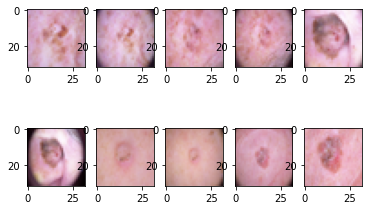

In [8]:
#print some image
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

# Image to Array

In [9]:
df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list())
#data = data.reshape(total_data,image_size*image_size*3).astype('float32')
data = data/255.0 #normalise the RGB value to [0...1]
label_to_one_hot = to_categorical(df['label'], num_classes=7)
#80% data for training
#20% data for testing
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.20,random_state=87,stratify=label_to_one_hot)

# Setup CNN model V1

In [10]:
num_classes = 7
dimension = image_size*image_size*3

model_CNN_V1 = Sequential()

#CNN layer 1:
model_CNN_V1.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(image_size,image_size,3),activation='relu',padding='same'))
model_CNN_V1.add(Dropout(0.1))
model_CNN_V1.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V1.add(MaxPooling2D(pool_size=(2,2)))

#CNN layer 2
model_CNN_V1.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V1.add(Dropout(0.1))
model_CNN_V1.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V1.add(MaxPooling2D(pool_size=(2,2)))

#CNN layer 3
model_CNN_V1.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V1.add(Dropout(0.1))
model_CNN_V1.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V1.add(MaxPooling2D(pool_size=(2,2)))

#Flatten layer
model_CNN_V1.add(Flatten())

#hidden layer 1
model_CNN_V1.add(Dense(2048,activation='relu'))
model_CNN_V1.add(Dropout(0.2))

#hidden layer 2
model_CNN_V1.add(Dense(1024,activation='relu'))
model_CNN_V1.add(Dropout(0.2))

#output layer
model_CNN_V1.add(Dense(7,activation='softmax'))
model_CNN_V1.summary()

model_CNN_V1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3

# Train CNN V1

In [11]:
try:
    model_CNN_V1.load_weights('../models/CNN_weight.h5')
except:
    print("new model_CNN_V1")

batch_size = 256
epochs = 200

train_history = model_CNN_V1.fit(
    train_data,train_label,
    epochs=epochs,
    validation_split=0.2,
    batch_size=batch_size,
    verbose=2,class_weight=class_weight)

new model_CNN_V1
Epoch 1/200
26/26 - 41s - loss: 1.7977 - acc: 0.6506 - val_loss: 1.1499 - val_acc: 0.6569
Epoch 2/200
26/26 - 36s - loss: 1.2466 - acc: 0.6726 - val_loss: 1.0643 - val_acc: 0.6569
Epoch 3/200
26/26 - 35s - loss: 1.1769 - acc: 0.6726 - val_loss: 1.0435 - val_acc: 0.6569
Epoch 4/200
26/26 - 36s - loss: 1.1402 - acc: 0.6726 - val_loss: 1.0224 - val_acc: 0.6569
Epoch 5/200
26/26 - 36s - loss: 1.1019 - acc: 0.6728 - val_loss: 0.9835 - val_acc: 0.6644
Epoch 6/200
26/26 - 36s - loss: 1.0665 - acc: 0.6822 - val_loss: 1.0651 - val_acc: 0.6563
Epoch 7/200
26/26 - 37s - loss: 1.1051 - acc: 0.6761 - val_loss: 0.9911 - val_acc: 0.6719
Epoch 8/200
26/26 - 35s - loss: 1.0497 - acc: 0.6844 - val_loss: 0.9368 - val_acc: 0.6675
Epoch 9/200
26/26 - 36s - loss: 1.0318 - acc: 0.6853 - val_loss: 0.9036 - val_acc: 0.6694
Epoch 10/200
26/26 - 36s - loss: 1.0012 - acc: 0.6883 - val_loss: 0.8639 - val_acc: 0.6806
Epoch 11/200
26/26 - 34s - loss: 0.9555 - acc: 0.6943 - val_loss: 0.9646 - val_acc

Epoch 91/200
26/26 - 16s - loss: 0.0104 - acc: 0.9975 - val_loss: 2.2821 - val_acc: 0.7367
Epoch 92/200
26/26 - 16s - loss: 0.0155 - acc: 0.9939 - val_loss: 2.3384 - val_acc: 0.7305
Epoch 93/200
26/26 - 15s - loss: 0.0232 - acc: 0.9927 - val_loss: 2.0376 - val_acc: 0.7305
Epoch 94/200
26/26 - 15s - loss: 0.0203 - acc: 0.9942 - val_loss: 2.1826 - val_acc: 0.7492
Epoch 95/200
26/26 - 15s - loss: 0.0158 - acc: 0.9955 - val_loss: 2.3220 - val_acc: 0.7399
Epoch 96/200
26/26 - 14s - loss: 0.0180 - acc: 0.9942 - val_loss: 2.2204 - val_acc: 0.7342
Epoch 97/200
26/26 - 15s - loss: 0.0110 - acc: 0.9966 - val_loss: 2.3158 - val_acc: 0.7361
Epoch 98/200
26/26 - 21s - loss: 0.0151 - acc: 0.9950 - val_loss: 2.3169 - val_acc: 0.7417
Epoch 99/200
26/26 - 25s - loss: 0.0186 - acc: 0.9938 - val_loss: 2.4475 - val_acc: 0.7392
Epoch 100/200
26/26 - 25s - loss: 0.0245 - acc: 0.9911 - val_loss: 2.1885 - val_acc: 0.7467
Epoch 101/200
26/26 - 24s - loss: 0.0306 - acc: 0.9906 - val_loss: 2.0201 - val_acc: 0.73

26/26 - 23s - loss: 0.0046 - acc: 0.9984 - val_loss: 2.7237 - val_acc: 0.7336
Epoch 181/200
26/26 - 22s - loss: 0.0075 - acc: 0.9975 - val_loss: 2.5926 - val_acc: 0.7349
Epoch 182/200
26/26 - 23s - loss: 0.0108 - acc: 0.9967 - val_loss: 2.5302 - val_acc: 0.7361
Epoch 183/200
26/26 - 25s - loss: 0.0163 - acc: 0.9939 - val_loss: 2.5953 - val_acc: 0.7342
Epoch 184/200
26/26 - 26s - loss: 0.0148 - acc: 0.9952 - val_loss: 2.2556 - val_acc: 0.7399
Epoch 185/200
26/26 - 26s - loss: 0.0101 - acc: 0.9966 - val_loss: 2.3332 - val_acc: 0.7286
Epoch 186/200
26/26 - 25s - loss: 0.0052 - acc: 0.9983 - val_loss: 2.5183 - val_acc: 0.7255
Epoch 187/200
26/26 - 26s - loss: 0.0098 - acc: 0.9969 - val_loss: 2.6480 - val_acc: 0.7361
Epoch 188/200
26/26 - 28s - loss: 0.0191 - acc: 0.9934 - val_loss: 2.4479 - val_acc: 0.7330
Epoch 189/200
26/26 - 30s - loss: 0.0132 - acc: 0.9958 - val_loss: 2.3350 - val_acc: 0.7336
Epoch 190/200
26/26 - 29s - loss: 0.0156 - acc: 0.9956 - val_loss: 2.3174 - val_acc: 0.7455
Ep

In [12]:
model_CNN_V1.save_weights('../models/CNN_weight.h5')
model_CNN_V1.save('../models/CNN_V1.h5')

# Apply Over Sampling

In [13]:
smote_sample = SMOTE(random_state=87)
train_data = train_data.reshape(-1,image_size*image_size*3)
train_data_oversample, train_label_oversample = smote_sample.fit_resample(train_data, train_label)
train_data_oversample = train_data_oversample.reshape(-1,image_size,image_size,3)
train_data = train_data.reshape(-1,image_size,image_size,3)

/Users/skylan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


# Setup CNN Model V2

In [14]:
num_classes = 7
dimension = image_size*image_size*3

model_CNN_V2 = Sequential()

#CNN layer 1:
model_CNN_V2.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(image_size,image_size,3),activation='relu',padding='same'))
model_CNN_V2.add(Dropout(0.2))
model_CNN_V2.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V2.add(MaxPooling2D(pool_size=(2,2)))

#CNN layer 2
model_CNN_V2.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V2.add(Dropout(0.2))
model_CNN_V2.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V2.add(MaxPooling2D(pool_size=(2,2)))

#CNN layer 3
model_CNN_V2.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V2.add(Dropout(0.2))
model_CNN_V2.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V2.add(MaxPooling2D(pool_size=(2,2)))

#Flatten layer
model_CNN_V2.add(Flatten())
model_CNN_V2.add(Dropout(0.4))

#hidden layer 1
model_CNN_V2.add(Dense(2048,activation='relu'))
model_CNN_V2.add(Dropout(0.4))

#hidden layer 2
model_CNN_V2.add(Dense(1024,activation='relu'))
model_CNN_V2.add(Dropout(0.4))

#output layer
model_CNN_V2.add(Dense(7,activation='softmax'))
model_CNN_V2.summary()

model_CNN_V2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)       

# Train CNN V2

In [ ]:
try:
    model_CNN_V2.load_weights('../models/CNN_V2_weight.h5')
except:
    print("new model_CNN_V2")

# Train
batch_size = 256
epochs = 200

train_history_2 = model_CNN_V2.fit(
    train_data_oversample,train_label_oversample,
    epochs=epochs,
    batch_size= batch_size,
    validation_split=0.2,
    verbose=2,shuffle=True)

In [ ]:
model_CNN_V2.save_weights('../models/CNN_V2_weight.h5')
model_CNN_V2.save('../models/CNN_V2.h5')

In [ ]:
def plot_model_accuracy(train_history, path):
    plt.plot(train_history.history['acc'])
    plt.plot(train_history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.savefig(path)
    plt.show()
    
def plot_model_loss(train_history, path):
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title("Model Loss")
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.savefig(path)
    plt.show()

# Train History

In [ ]:
#plot train history
print("V1")
plot_model_accuracy(train_history, '../plots/CNN_V1_training_history.jpg')
print("V2")
plot_model_accuracy(train_history, '../plots/CNN_V2_training_history.jpg')

# Loss

In [ ]:
print("V1")
plot_model_loss(train_history, '../plots/CNN_V1_training_loss.jpg')
print("V2")
plot_model_loss(train_history, '../plots/CNN_V2_training_loss.jpg')

# Prediction score

In [ ]:
#score
score = model_CNN_V1.evaluate(test_data, test_label)
print('Test accuracy for CNN V1:', score[1])

#score
score2 = model_CNN_V2.evaluate(test_data, test_label)
print('Test accuracy: for CNN V2', score2[1])

# Confusion Matrix

In [ ]:
#predictions
print("confusion matrix for CNN V1")
prediction = model_CNN_V1.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
prediction_label = np.argmax(test_label,axis=1)

#confusion matrix
mapping = lambda x:features_dict[x]
pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
pred_label_to_feature = np.array([mapping(x) for x in prediction_label])
#pred_label_to_feature = prediction_label.map(lambda x:features_dict[x])

#confusion matrix
print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,rownames=['actual'],colnames=['predicted']))

#predictions

print("confusion matrix for CNN V2")
prediction_2 = model_CNN_V2.predict(test_data)

prediction_class_2 = np.argmax(prediction_2,axis=1)
prediction_label_2 = np.argmax(test_label,axis=1)

#confusion matrix
mapping = lambda x:features_dict[x]
pred_class_to_feature_2 = np.array([mapping(x) for x in prediction_class_2])
pred_label_to_feature_2 = np.array([mapping(x) for x in prediction_label_2])
#pred_label_to_feature = prediction_label.map(lambda x:features_dict[x])

#confusion matrix
print(pd.crosstab(pred_label_to_feature_2,pred_class_to_feature_2,rownames=['actual'],colnames=['predicted']))